In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
file_path = 'datos_iniciales_anonimizados.csv'
data = pd.read_csv(file_path)

# Mostrar las primeras filas para inspeccionar la estructura del archivo
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   deployments            88 non-null     object 
 1   CPU_REQUESTS           88 non-null     float64
 2   MEMORY_REQUESTS_in_MB  88 non-null     float64
 3   CPU_95                 88 non-null     float64
 4   Memory_95              88 non-null     float64
dtypes: float64(4), object(1)
memory usage: 3.6+ KB


In [3]:
# Calcular CPU_95_MARGEN y MEMORY_95_MARGEN
data['CPU_95_MARGEN'] = (data['CPU_95'] * 1.15).round(4)
data['MEMORY_95_MARGEN'] = (data['Memory_95'] * 1.15).round(2)

# Verificar las nuevas columnas
data[['CPU_95', 'CPU_95_MARGEN', 'Memory_95', 'MEMORY_95_MARGEN']].head()


,CPU_95,CPU_95_MARGEN,Memory_95,MEMORY_95_MARGEN
0,0.0058,0.0067,482.75,555.16
1,0.0114,0.0131,2338.59,2689.38
2,0.0058,0.0067,342.24,393.58
3,0.0596,0.0685,231.76,266.52
4,0.0254,0.0292,570.16,655.68


In [4]:
# CPU_REQUEST_CORRECTO
data['CPU_REQUEST_CORRECTO'] = np.where(
    data['CPU_REQUESTS'].between(data['CPU_95'], data['CPU_95_MARGEN'], inclusive='both') & 
    data['CPU_REQUESTS'].notnull() & 
    data['CPU_95'].notnull() & 
    data['CPU_95_MARGEN'].notnull(),
    True,
    False
)

# MEMORY_REQUEST_CORRECTO
data['MEMORY_REQUEST_CORRECTO'] = np.where(
    data['MEMORY_REQUESTS_in_MB'].between(data['Memory_95'], data['MEMORY_95_MARGEN'], inclusive='both') & 
    data['MEMORY_REQUESTS_in_MB'].notnull() & 
    data['Memory_95'].notnull() & 
    data['MEMORY_95_MARGEN'].notnull(),
    True,
    False
)


In [5]:
# CPU_SUBASIGNADO
data['CPU_SUBASIGNADO'] = np.where(
    data['CPU_REQUESTS'] < data['CPU_95'],
    True,
    False
)
data['CPU_SUBASIGNADO'] = data['CPU_SUBASIGNADO'] & data['CPU_REQUESTS'].notnull() & data['CPU_95'].notnull()

# MEMORY_SUBASIGNADO
data['MEMORY_SUBASIGNADO'] = np.where(
    data['MEMORY_REQUESTS_in_MB'] < data['Memory_95'],
    True,
    False
)
data['MEMORY_SUBASIGNADO'] = data['MEMORY_SUBASIGNADO'] & data['MEMORY_REQUESTS_in_MB'].notnull() & data['Memory_95'].notnull()


In [6]:
# CPU_SOBREASIGNADO
data['CPU_SOBREASIGNADO'] = np.where(
    data['CPU_REQUESTS'] > data['CPU_95_MARGEN'],
    True,
    False
)
data['CPU_SOBREASIGNADO'] = data['CPU_SOBREASIGNADO'] & data['CPU_REQUESTS'].notnull() & data['CPU_95_MARGEN'].notnull()

# MEMORY_SOBREASIGNADO
data['MEMORY_SOBREASIGNADO'] = np.where(
    data['MEMORY_REQUESTS_in_MB'] > data['MEMORY_95_MARGEN'],
    True,
    False
)
data['MEMORY_SOBREASIGNADO'] = data['MEMORY_SOBREASIGNADO'] & data['MEMORY_REQUESTS_in_MB'].notnull() & data['MEMORY_95_MARGEN'].notnull()


In [7]:
# SIN_ASIGNAR_CPU
data['SIN_ASIGNAR_CPU'] = data['CPU_REQUESTS'].isnull() | data['CPU_95'].isnull() | data['CPU_95_MARGEN'].isnull()

# SIN_ASIGNAR_MEMORY
data['SIN_ASIGNAR_MEMORY'] = data['MEMORY_REQUESTS_in_MB'].isnull() | data['Memory_95'].isnull() | data['MEMORY_95_MARGEN'].isnull()


In [8]:
data.head()

,deployments,CPU_REQUESTS,MEMORY_REQUESTS_in_MB,CPU_95,Memory_95,CPU_95_MARGEN,MEMORY_95_MARGEN,CPU_REQUEST_CORRECTO,MEMORY_REQUEST_CORRECTO,CPU_SUBASIGNADO,MEMORY_SUBASIGNADO,CPU_SOBREASIGNADO,MEMORY_SOBREASIGNADO,SIN_ASIGNAR_CPU,SIN_ASIGNAR_MEMORY
0,deploy1,0.1,209.72,0.0058,482.75,0.0067,555.16,False,False,False,True,True,False,False,False
1,deploy2,0.1,209.72,0.0114,2338.59,0.0131,2689.38,False,False,False,True,True,False,False,False
2,deploy3,0.3,3145.74,0.0058,342.24,0.0067,393.58,False,False,False,False,True,True,False,False
3,deploy4,0.3,314.57,0.0596,231.76,0.0685,266.52,False,False,False,False,True,True,False,False
4,deploy5,0.1,367.00,0.0254,570.16,0.0292,655.68,False,False,False,True,True,False,False,False


In [9]:
# Ajustar columnas CPU
data.loc[data['SIN_ASIGNAR_CPU'], ['CPU_REQUEST_CORRECTO', 'CPU_SUBASIGNADO', 'CPU_SOBREASIGNADO']] = False

# Asegurar que solo una de las condiciones sea True
cpu_conditions = ['CPU_REQUEST_CORRECTO', 'CPU_SUBASIGNADO', 'CPU_SOBREASIGNADO']
data[cpu_conditions] = data[cpu_conditions].astype(bool)

# Verificar si más de una condición es True y corregir si es necesario
for index, row in data.iterrows():
    if data.loc[index, 'SIN_ASIGNAR_CPU']:
        continue  # Ya está ajustado
    true_conditions = row[cpu_conditions].sum()
    if true_conditions > 1:
        # Priorizar Correcto > Subasignado > Sobreasignado
        if row['CPU_REQUEST_CORRECTO']:
            data.at[index, 'CPU_SUBASIGNADO'] = False
            data.at[index, 'CPU_SOBREASIGNADO'] = False
        elif row['CPU_SUBASIGNADO']:
            data.at[index, 'CPU_SOBREASIGNADO'] = False

# Ajustar columnas Memory
data.loc[data['SIN_ASIGNAR_MEMORY'], ['MEMORY_REQUEST_CORRECTO', 'MEMORY_SUBASIGNADO', 'MEMORY_SOBREASIGNADO']] = False

# Asegurar que solo una de las condiciones sea True
memory_conditions = ['MEMORY_REQUEST_CORRECTO', 'MEMORY_SUBASIGNADO', 'MEMORY_SOBREASIGNADO']
data[memory_conditions] = data[memory_conditions].astype(bool)

# Verificar si más de una condición es True y corregir si es necesario
for index, row in data.iterrows():
    if data.loc[index, 'SIN_ASIGNAR_MEMORY']:
        continue  # Ya está ajustado
    true_conditions = row[memory_conditions].sum()
    if true_conditions > 1:
        # Priorizar Correcto > Subasignado > Sobreasignado
        if row['MEMORY_REQUEST_CORRECTO']:
            data.at[index, 'MEMORY_SUBASIGNADO'] = False
            data.at[index, 'MEMORY_SOBREASIGNADO'] = False
        elif row['MEMORY_SUBASIGNADO']:
            data.at[index, 'MEMORY_SOBREASIGNADO'] = False


In [11]:
# Definir el orden deseado de las columnas
orden_columnas = [
    'deployments',
    
    # Columnas relacionadas con CPU
    'CPU_REQUESTS',
    'CPU_95',
    'CPU_95_MARGEN',
    'CPU_REQUEST_CORRECTO',
    'CPU_SUBASIGNADO',
    'CPU_SOBREASIGNADO',
    'SIN_ASIGNAR_CPU',
    
    # Columnas relacionadas con Memoria
    'MEMORY_REQUESTS_in_MB',
    'Memory_95',
    'MEMORY_95_MARGEN',
    'MEMORY_REQUEST_CORRECTO',
    'MEMORY_SUBASIGNADO',
    'MEMORY_SOBREASIGNADO',
    'SIN_ASIGNAR_MEMORY'
]

# Definir las columnas relevantes para CPU y Memoria
columnas_cpu = [
    'CPU_REQUEST_CORRECTO',
    'CPU_SUBASIGNADO',
    'CPU_SOBREASIGNADO',
    'SIN_ASIGNAR_CPU'
]

columnas_memory = [
    'MEMORY_REQUEST_CORRECTO',
    'MEMORY_SUBASIGNADO',
    'MEMORY_SOBREASIGNADO',
    'SIN_ASIGNAR_MEMORY'
]

# Reordenar las columnas del DataFrame según el orden definido
data = data[orden_columnas]
# Mostrar las primeras filas con las nuevas columnas
data.head()


,deployments,CPU_REQUESTS,CPU_95,CPU_95_MARGEN,CPU_REQUEST_CORRECTO,CPU_SUBASIGNADO,CPU_SOBREASIGNADO,SIN_ASIGNAR_CPU,MEMORY_REQUESTS_in_MB,Memory_95,MEMORY_95_MARGEN,MEMORY_REQUEST_CORRECTO,MEMORY_SUBASIGNADO,MEMORY_SOBREASIGNADO,SIN_ASIGNAR_MEMORY
0,deploy1,0.1,0.0058,0.0067,False,False,True,False,209.72,482.75,555.16,False,True,False,False
1,deploy2,0.1,0.0114,0.0131,False,False,True,False,209.72,2338.59,2689.38,False,True,False,False
2,deploy3,0.3,0.0058,0.0067,False,False,True,False,3145.74,342.24,393.58,False,False,True,False
3,deploy4,0.3,0.0596,0.0685,False,False,True,False,314.57,231.76,266.52,False,False,True,False
4,deploy5,0.1,0.0254,0.0292,False,False,True,False,367.00,570.16,655.68,False,True,False,False


In [12]:
from IPython.display import display, HTML

# Contar los valores True en cada columna
frecuencia_cpu = data[columnas_cpu].sum()
frecuencia_memory = data[columnas_memory].sum()

# Convertir a DataFrame para facilitar la visualización
frecuencia_cpu = frecuencia_cpu.reset_index()
frecuencia_cpu.columns = ['Categoría', 'Frecuencia']
frecuencia_memory = frecuencia_memory.reset_index()
frecuencia_memory.columns = ['Categoría', 'Frecuencia']

# Mostrar las tablas sin índices usando estilos
print("Frecuencia de asignación de CPU request inicial:")
display(HTML(frecuencia_cpu.to_html(index=False)))

print("\nFrecuencia de asignación de Memory request inicial:")
display(HTML(frecuencia_memory.to_html(index=False)))

Frecuencia de asignación de CPU request inicial:


Categoría,Frecuencia
CPU_REQUEST_CORRECTO,4
CPU_SUBASIGNADO,13
CPU_SOBREASIGNADO,71
SIN_ASIGNAR_CPU,0



Frecuencia de asignación de Memory request inicial:


Categoría,Frecuencia
MEMORY_REQUEST_CORRECTO,6
MEMORY_SUBASIGNADO,40
MEMORY_SOBREASIGNADO,42
SIN_ASIGNAR_MEMORY,0


In [13]:
AZUL = "#0072B2"        # Azul fuerte
NARANJA = "#D55E00"     # Naranja fuerte
VERDE = "#009E73"        # Verde fuerte
ROSA = "#CC79A7"         # Rosa magenta fuerte

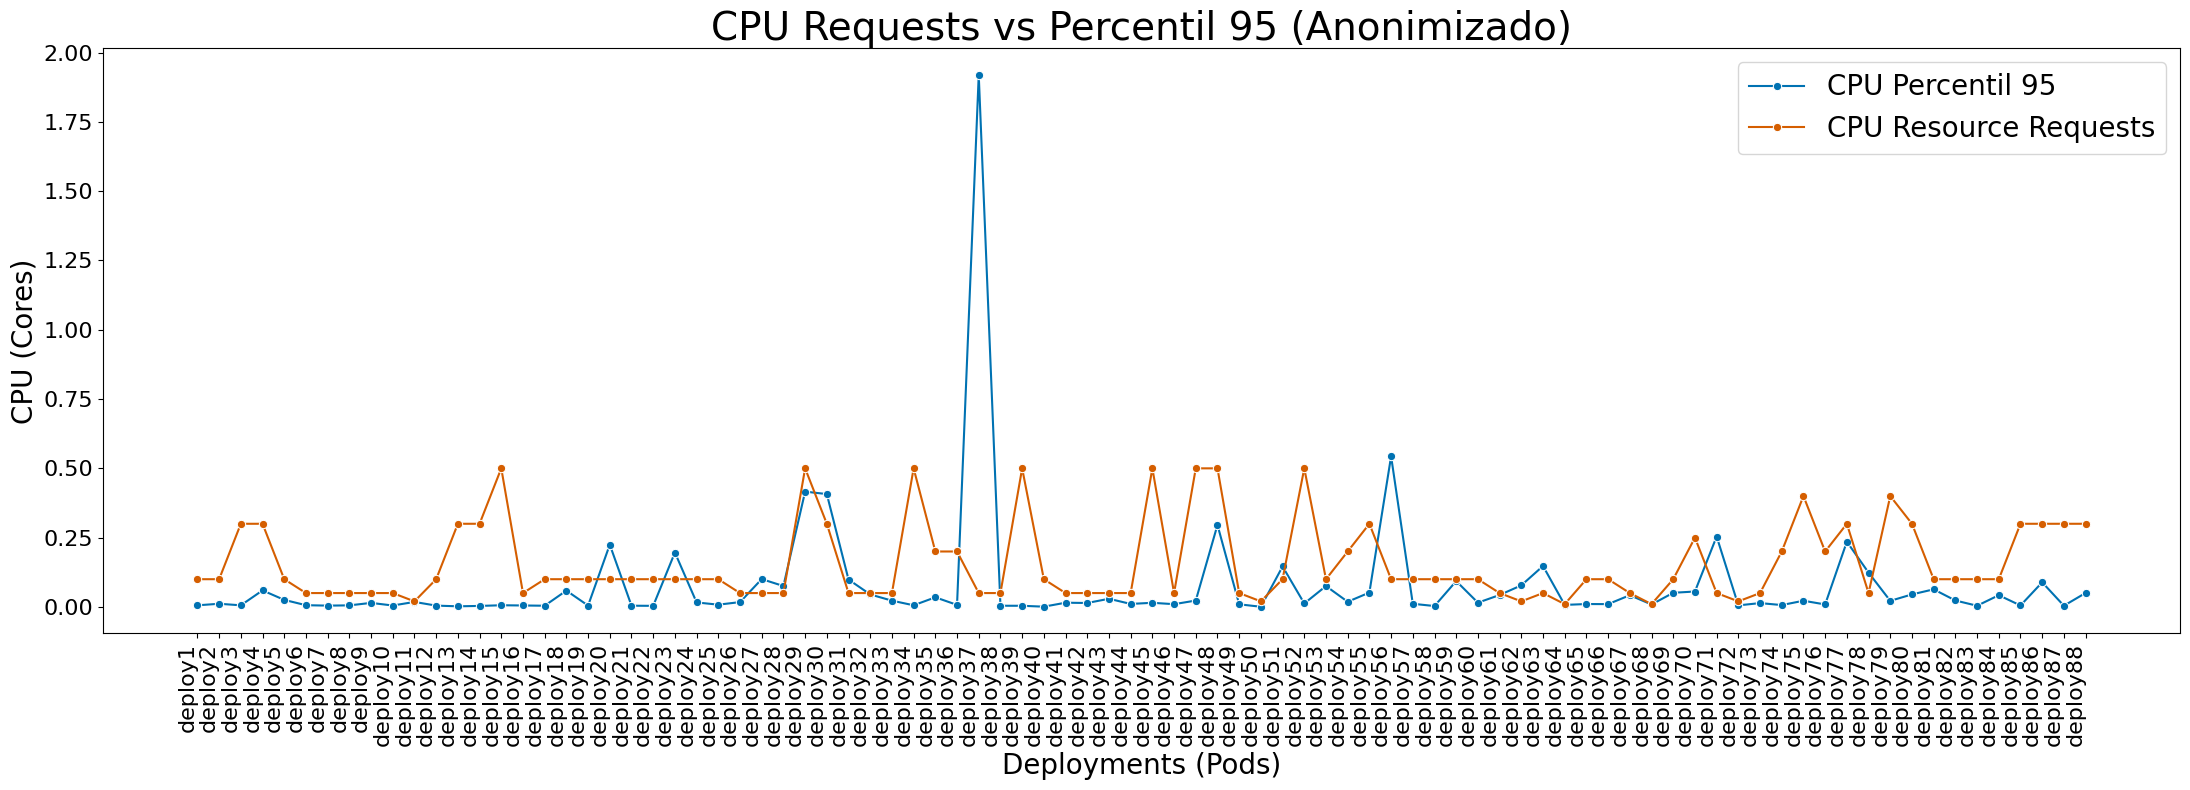

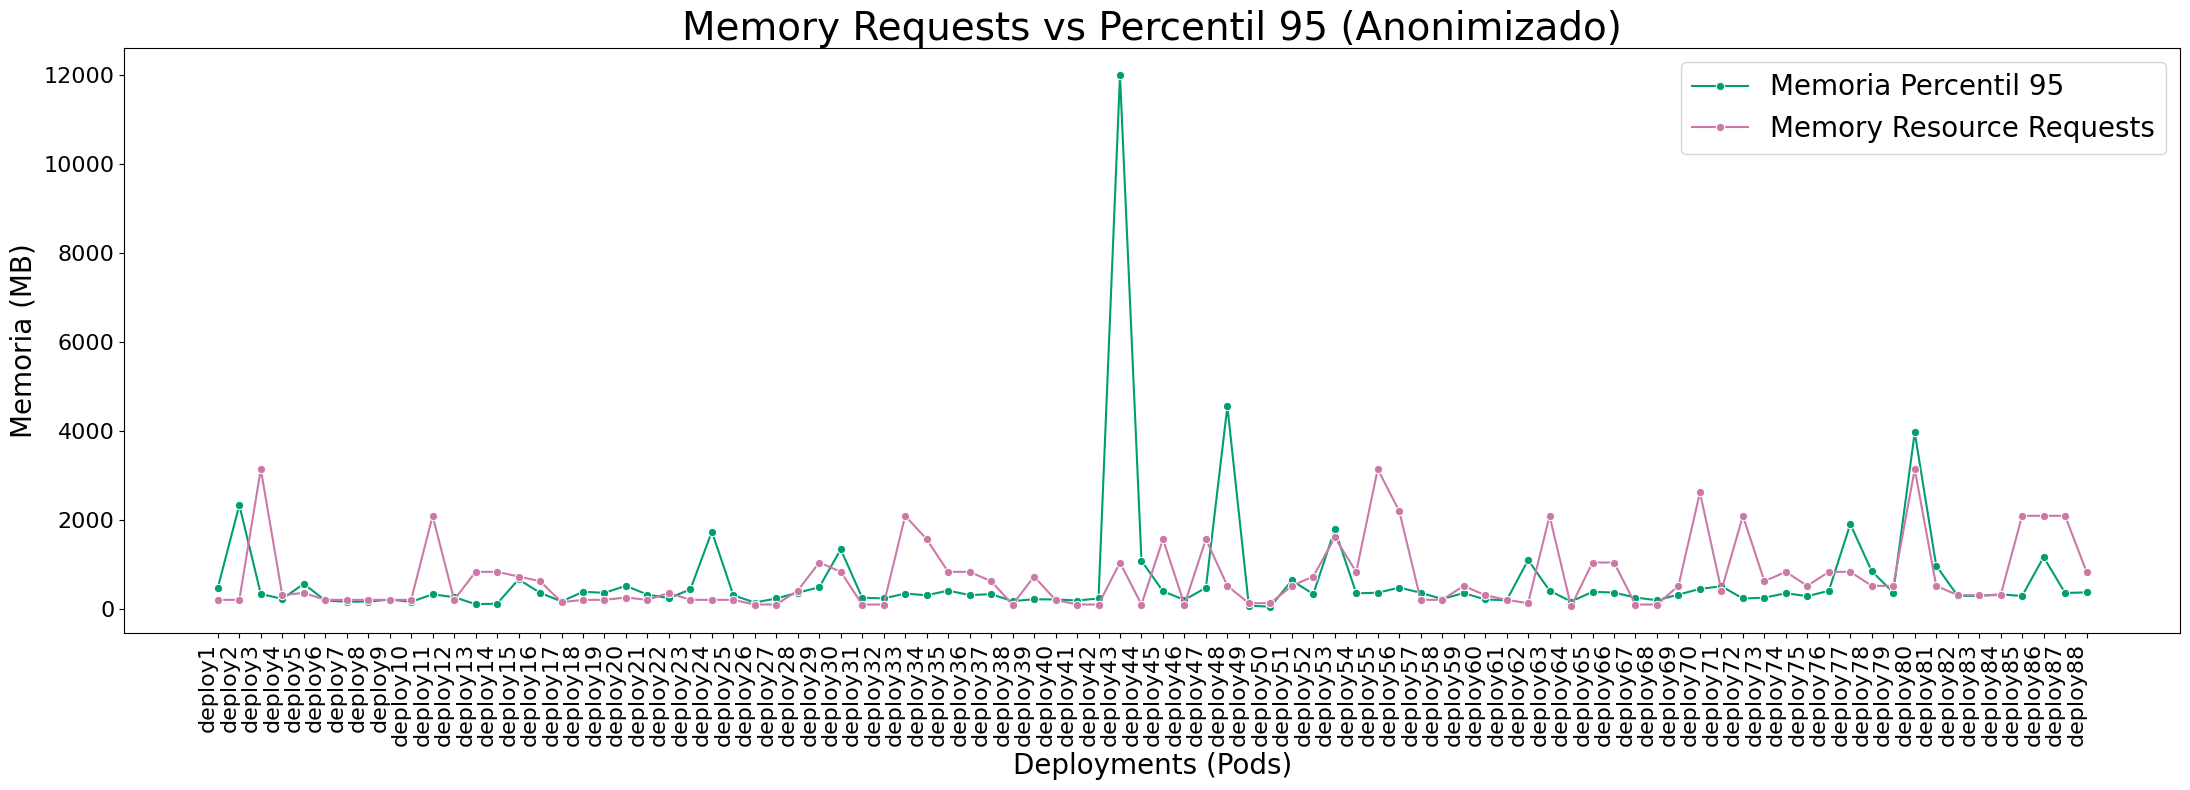

In [14]:
# Gráfico de CPU
plt.figure(figsize=(22, 8))
sns.lineplot(x='deployments', y='CPU_95', data=data, marker='o', label='CPU Percentil 95', color=AZUL)
sns.lineplot(x='deployments', y='CPU_REQUESTS', data=data, marker='o', label='CPU Resource Requests', color=NARANJA)
plt.ylabel('CPU (Cores)', fontsize=20)
plt.title('CPU Requests vs Percentil 95 (Anonimizado)', fontsize=28)
plt.xticks(rotation=90, ha='right', fontsize=16)  
plt.yticks(fontsize=16)  
plt.xlabel('Deployments (Pods)', fontsize=20)  
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()

# Gráfico de Memoria
plt.figure(figsize=(22, 8))
sns.lineplot(x='deployments', y='Memory_95', data=data, marker='o', label='Memoria Percentil 95', color=VERDE)
sns.lineplot(x='deployments', y='MEMORY_REQUESTS_in_MB', data=data, marker='o', label='Memory Resource Requests', color=ROSA)
plt.ylabel('Memoria (MB)', fontsize=20)
plt.title('Memory Requests vs Percentil 95 (Anonimizado)', fontsize=28)
plt.xticks(rotation=90, ha='right', fontsize=16)  
plt.yticks(fontsize=16)  
plt.xlabel('Deployments (Pods)', fontsize=20)  
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()